In [40]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

Pergunta?

Será que é possível indicar cervejas que o usuário vai gostar sabendo as que ele ja experimentou? E se for possível, quão bem podemos fazer isso? Se conseguimos recomendar só aquilo que é parecido com o que ele gosta, estaremos o empurrando para um bolha?

Detalhar o get, de onde esses dados vieram e o que eles significam

GET: https://www.kaggle.com/code/ruthgn/data-cleaning-integration-pandas-fuzzywuzzy/input

In [41]:
df = pd.read_csv('beer_review.csv')

In [42]:
#QUANTAS COLUNAS(FEATURES) NÓS POSSUIMOS?

In [43]:
df.shape

(5558, 21)

In [44]:
df.head(30)

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Body,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty
0,Amber,251,Altbier,8,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,...,32,9,47,74,33,0,33,57,8,111
1,Double Bag,252,Altbier,8,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,...,57,18,33,55,16,0,24,35,12,84
2,Long Trail Ale,253,Altbier,8,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,...,37,6,42,43,11,0,10,54,4,62
3,Doppelsticke,254,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,...,55,31,47,101,18,1,49,40,16,119
4,Scurry,255,Altbier,8,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,...,69,10,63,120,14,0,19,36,15,218
5,Sleigh'r Dark Doüble Alt Ale,256,Altbier,8,Ninkasi Brewing Company,Notes:Called 'Dark Double Alt' on the label.Se...,7.2,3.78,25,50,...,51,26,44,45,9,1,11,51,20,95
6,Sticke,257,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,6.0,4.10,25,50,...,45,13,46,62,25,1,34,60,4,103
7,Okto Festival Ale,258,Altbier,8,Widmer Brothers Brewing Company,Notes:Classified as a German Altbier by the Wi...,5.3,3.46,25,50,...,40,3,40,58,29,0,36,54,8,97
8,Southampton Altbier,259,Altbier,8,Southampton Publick House,Notes:,5.0,3.60,25,50,...,49,5,37,73,22,0,21,37,4,98
9,Copper,260,Altbier,8,The Olde Mecklenburg Brewery,"Notes:OMB’s flagship, Copper, is an authentic ...",4.8,4.10,25,50,...,35,4,38,39,13,1,8,60,16,97


Temos ABV como o teor alcoolico em porcentagem

AVE é a nota média de uma cerveja

IBU: Na tradução literal seria algo como Unidade Internacional de Amargor, uma escala através da qual pode-se ter uma ideia do quão amarga é a bebida.
As unidades de amargor são medidas em uma escala que vai de 1 a 100 IBUs.
É por isso que as cervejas costumam ter entre 5 e 100 IBUs, sendo 5 um amargor bem baixo e 100 um amargor bem alto.

Nos nossos dados, o ibu parece padrão e sem um bom valor estabelecido

Astringency: Seria a sensação de "secura" associada a cerveja onde nos parece ser uma medida subjetiva e sem muito significado

Em body temos uma classificação támbem subjetiva a respeito do "corpo" da cerveja. Isto é, sensação de peso, textura ou viscosidade

Leve: Cervejas com corpo leve tendem a ter uma sensação líquida e refrescante na boca, com baixa viscosidade.

Médio: Cervejas com corpo médio têm uma sensação mais equilibrada na boca, proporcionando uma sensação mais arredondada e um pouco mais de peso.

Encorpado: Cervejas com corpo encorpado têm uma sensação mais pesada, viscosa e densa na boca.


Alcohol é uma feedback subjetivo sobre a sensação alcolica de uma cerveja.

Bitter é uma classificação subjetiva a cerca da sensação de amargor de uma cerveja

Sweet: descrição subjetiva da doçura de uma cerveja

Sour descrição subjetiva "azedo" ou "ácido"

Salty: descreve subjetivamente o salgado, termo não é comumente associado às bebidas em si, pois o sabor salgado é geralmente mais associado a alimentos do que a bebidas. No entanto, em algumas culturas ou contextos, podem existir coquetéis ou bebidas que incorporam um toque sutil de sal, embora isso não seja tão comum.

Fruits: Algumas cervejas são produzidas com a adição de frutas durante a fermentação, o que pode resultar em uma ampla variedade de sabores frutados. Essa coluna mede essa frutificação de maneira subjetiva

Hoppy: Quando uma cerveja é descrita como "hoppy", isso geralmente significa que ela possui uma quantidade significativa de lúpulo em sua composição, o que pode resultar em várias características sensoriais:

Amargor: O lúpulo é responsável por adicionar o amargor à cerveja, equilibrando o sabor do malte e fornecendo uma sensação de amargor na língua.

Aroma floral e frutado: Diferentes variedades de lúpulo podem contribuir com aromas e sabores frutados, cítricos, florais, herbais e até mesmo resinosos à cerveja, criando uma grande diversidade de perfis aromáticos.

Sabor de lúpulo: Cervejas hoppy podem ter um sabor distintamente "verde" ou "resinoso" de lúpulo, especialmente em cervejas mais intensamente lupuladas, como as India Pale Ales (IPAs) e Double IPAs (DIPAs).

ps: testar correlação (para dados discretos) para verificar se esse campo entrega o mesmo resultado que o Bitter e ibu

Spicy: Algumas bebidas alcoólicas podem ser descritas como "spicy" devido à presença de especiarias, como canela, cravo, pimenta-da-jamaica, gengibre, cardamomo, entre outras. Essas especiarias podem ser adicionadas diretamente à bebida ou como parte de licores ou xaropes utilizados nos coquetéis.

Malty: Quando uma cerveja é descrita como "malty", isso geralmente significa que ela possui uma quantidade significativa de malte em sua composição, o que pode resultar em várias características sensoriais:

Sabor doce: O malte contém açúcares que são fermentados pelas leveduras durante o processo de fabricação de cerveja. Isso pode resultar em cervejas com um sabor doce proveniente desses açúcares não fermentados.

Aroma de pão, biscoito ou caramelo: Diferentes tipos de maltes podem conferir aromas distintos à cerveja, como notas de pão, biscoito ou caramelo, criando uma variedade de perfis de aroma maltado.

Cor mais escura: Cervejas malty podem ter uma cor mais escura, que varia de dourado a âmbar, marrom ou mesmo preto, dependendo dos tipos e quantidades de maltes utilizados.

Sabor maltado equilibrado: Uma cerveja malty bem elaborada deve equilibrar o sabor do malte com outros sabores presentes, como o amargor do lúpulo, o álcool e outros sabores derivados do processo de fermentação.

In [45]:
df.nunique()

Name           5317
key            5558
Style           112
Style Key       112
Brewery        1498
Description    3347
ABV             229
Ave Rating      289
Min IBU          21
Max IBU          25
Astringency      73
Body            165
Alcohol         116
Bitter          141
Sweet           191
Sour            222
Salty            47
Fruits          185
Hoppy           156
Spices          155
Malty           217
dtype: int64

In [46]:
df['mean ibu'] = (df['Min IBU']+df['Max IBU'])/2

In [47]:
df

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Alcohol,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,mean ibu
0,Amber,251,Altbier,8,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,...,9,47,74,33,0,33,57,8,111,37.5
1,Double Bag,252,Altbier,8,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,...,18,33,55,16,0,24,35,12,84,37.5
2,Long Trail Ale,253,Altbier,8,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,...,6,42,43,11,0,10,54,4,62,37.5
3,Doppelsticke,254,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,...,31,47,101,18,1,49,40,16,119,37.5
4,Scurry,255,Altbier,8,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,...,10,63,120,14,0,19,36,15,218,37.5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5553,Red Nose Winter Ale,696,Winter Warmer,17,Natty Greene's Pub & Brewing Co.,Notes:,6.8,3.59,35,50,...,24,19,52,21,0,26,21,96,77,42.5
5554,Our Special Ale 2019 (Anchor Christmas Ale),697,Winter Warmer,17,Anchor Brewing Company,Notes:This is the forty-fifth annual Our Speci...,6.9,3.79,35,50,...,9,58,87,23,0,48,91,44,104,42.5
5555,Fish Tale Winterfish,698,Winter Warmer,17,Fish Brewing Company / Fishbowl Brewpub,Notes:,7.5,3.76,35,50,...,50,70,72,59,0,81,110,18,73,42.5
5556,"He'Brew Hanukkah, Chanukah: Pass The Beer",699,Winter Warmer,17,Shmaltz Brewing Company,Notes:Chanukah Beer pours a rich crystal clear...,8.0,3.61,35,50,...,30,57,78,15,1,28,57,23,129,42.5


Uma coluna que chama atenção é o salty, isso pois, não é de nosso cotidiano analisar o quão salgada uma cerveja é. Será que essa coluna é realmente útil?

In [48]:
salty = df['Salty']
salty.describe()

count    5558.000000
mean        1.314142
std         3.874110
min         0.000000
25%         0.000000
50%         0.000000
75%         1.000000
max        66.000000
Name: Salty, dtype: float64

In [49]:
(salty == 0).sum()

3369

In [50]:
(salty == 1).sum()

936

In [51]:
max(salty)

66

Vemos aqui que a imensa maioria dos valores são 0 e outra grande parte 1. Contudo a escala vai até 66. O que mostra que o aspecto salty pode não possuir muita relevância

In [52]:
df.nunique()

Name           5317
key            5558
Style           112
Style Key       112
Brewery        1498
Description    3347
ABV             229
Ave Rating      289
Min IBU          21
Max IBU          25
Astringency      73
Body            165
Alcohol         116
Bitter          141
Sweet           191
Sour            222
Salty            47
Fruits          185
Hoppy           156
Spices          155
Malty           217
mean ibu         35
dtype: int64

Outro aspecto interessante, é que o ibu não foi dado um número exato, ele foi dado em intervalo, isso pois, não se havia certeza 

In [53]:
df['ibu'] = df['Min IBU'].astype(str) + ' - ' + df['Max IBU'].astype(str)

In [54]:
df

,Name,key,Style,Style Key,Brewery,Description,ABV,Ave Rating,Min IBU,Max IBU,...,Bitter,Sweet,Sour,Salty,Fruits,Hoppy,Spices,Malty,mean ibu,ibu
0,Amber,251,Altbier,8,Alaskan Brewing Co.,"Notes:Richly malty and long on the palate, wit...",5.3,3.65,25,50,...,47,74,33,0,33,57,8,111,37.5,25 - 50
1,Double Bag,252,Altbier,8,Long Trail Brewing Co.,"Notes:This malty, full-bodied double alt is al...",7.2,3.90,25,50,...,33,55,16,0,24,35,12,84,37.5,25 - 50
2,Long Trail Ale,253,Altbier,8,Long Trail Brewing Co.,Notes:Long Trail Ale is a full-bodied amber al...,5.0,3.58,25,50,...,42,43,11,0,10,54,4,62,37.5,25 - 50
3,Doppelsticke,254,Altbier,8,Uerige Obergärige Hausbrauerei,Notes:,8.5,4.15,25,50,...,47,101,18,1,49,40,16,119,37.5,25 - 50
4,Scurry,255,Altbier,8,Off Color Brewing,Notes:Just cause it's dark and German doesn't ...,5.3,3.67,25,50,...,63,120,14,0,19,36,15,218,37.5,25 - 50
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5553,Red Nose Winter Ale,696,Winter Warmer,17,Natty Greene's Pub & Brewing Co.,Notes:,6.8,3.59,35,50,...,19,52,21,0,26,21,96,77,42.5,35 - 50
5554,Our Special Ale 2019 (Anchor Christmas Ale),697,Winter Warmer,17,Anchor Brewing Company,Notes:This is the forty-fifth annual Our Speci...,6.9,3.79,35,50,...,58,87,23,0,48,91,44,104,42.5,35 - 50
5555,Fish Tale Winterfish,698,Winter Warmer,17,Fish Brewing Company / Fishbowl Brewpub,Notes:,7.5,3.76,35,50,...,70,72,59,0,81,110,18,73,42.5,35 - 50
5556,"He'Brew Hanukkah, Chanukah: Pass The Beer",699,Winter Warmer,17,Shmaltz Brewing Company,Notes:Chanukah Beer pours a rich crystal clear...,8.0,3.61,35,50,...,57,78,15,1,28,57,23,129,42.5,35 - 50


In [55]:
df['ibu'].nunique()

52

Vemos aqui que possuimos 52 intervalos possíveis para o ibu

Vamo agora analisar as colunas que tem valores subjetivos dados pelos usuários

In [56]:
colunas = ['Malty','Spices','Hoppy','Fruits','Sour','Sweet','Bitter','Alcohol','Body',"Astringency"]

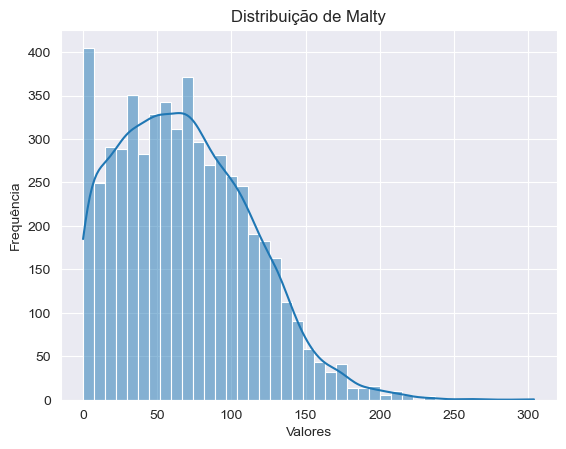

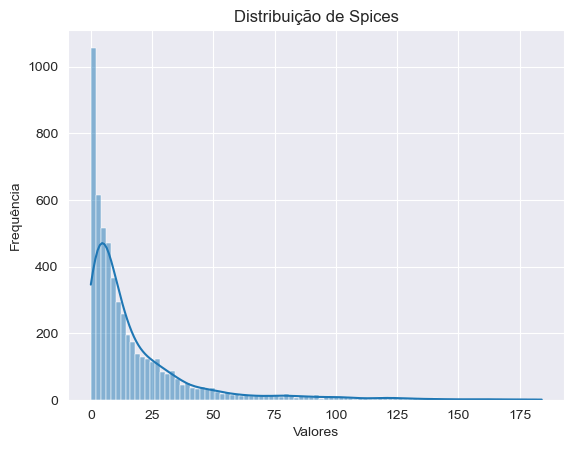

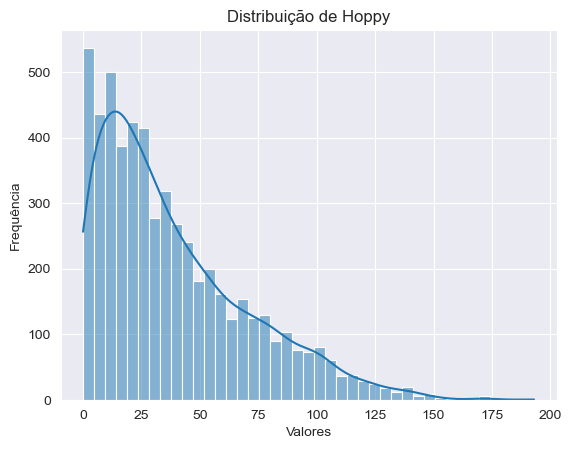

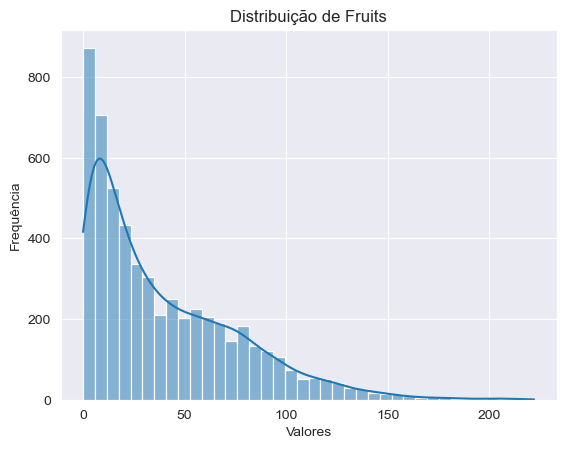

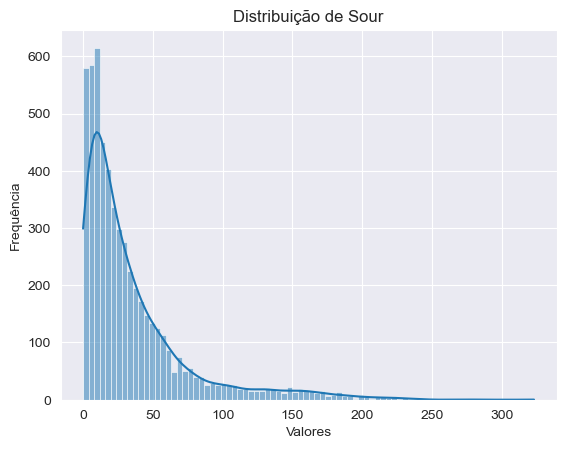

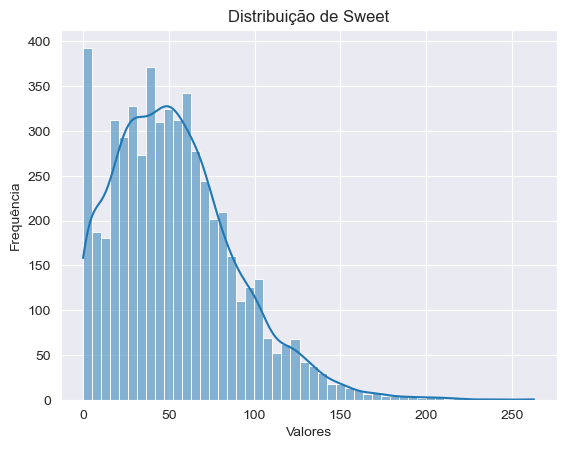

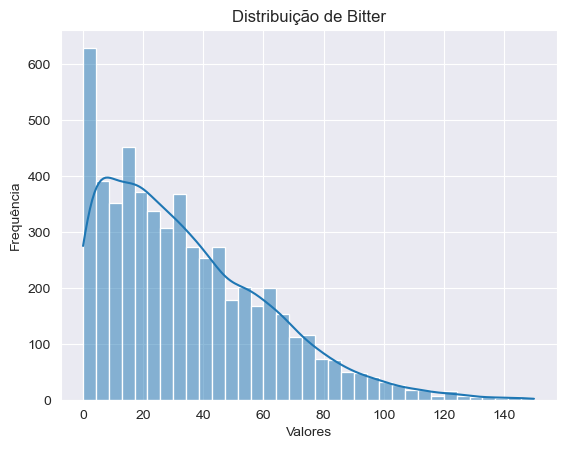

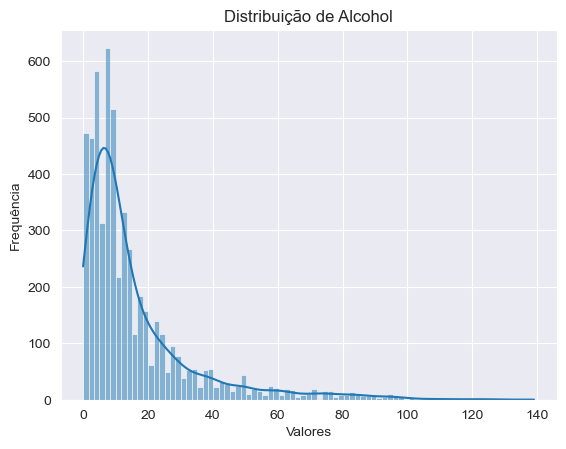

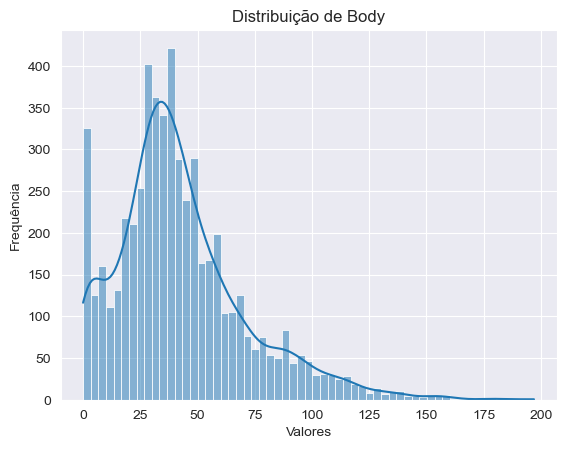

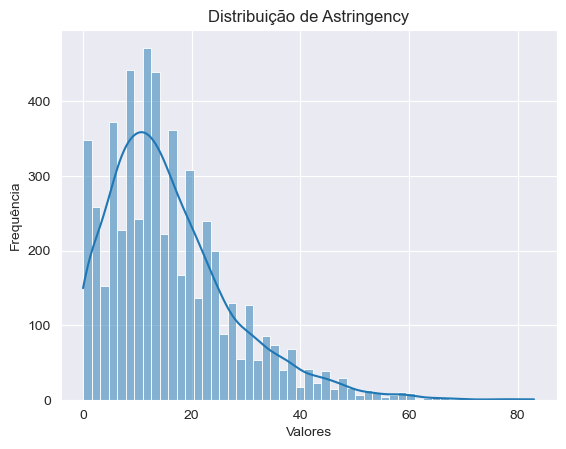

In [57]:
for coluna in colunas:
    sns.histplot(data=df, x=coluna, kde=True)

# Adicionar rótulos e título ao gráfico
    plt.xlabel('Valores')
    plt.ylabel('Frequência')
    plt.title(f'Distribuição de {coluna}')

# Exibir o gráfico
    plt.show()

Uau, de certa forma todas colunas parecem seguir o mesmo padrão de distribuição...

Sabemos que as olunas analisadas são dados númericos discretos.

Existe então a hipotose de que esses dados seguem a distribuição de Poisson, agora vamos verificar

In [58]:
from scipy.stats import chi2_contingency
from scipy.stats import shapiro

nivel_significancia = 0.05
for coluna in colunas:
    media = df[coluna].mean()
    var = df[coluna].var()
    
    print(media,var)
    
#não consegui realizar testes estatísticos para descobrir a distribuição.


68.591399784095 1989.194361869652
17.58402302986686 574.7468528423701
38.41453760345448 1018.4295312869623
39.37855343648795 1343.3905926884377
34.610291471752426 1588.0406498700388
53.62972292191436 1286.3771764933022
34.31612090680101 735.3913218583314
15.97517092479309 333.7323328392157
42.746131702051095 817.3857822263093
15.938646995322058 135.12328209922757


Será que existem colunas que são explicadas por outras colunas?

Vamos fazer o coeficiente de correlação de spearman, ja que nossos dados são

In [59]:
colunas_t = ['Malty','Spices','Hoppy','Fruits','Sour','Sweet','Bitter','Alcohol','Body',"Astringency", 'ABV','Ave Rating','mean ibu']
notas = df.filter(items=colunas_t)

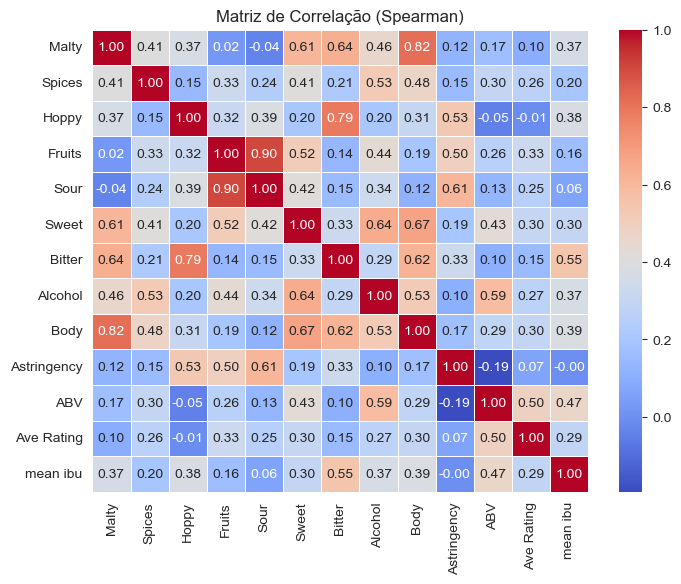

In [60]:
import seaborn as sns
matriz_correlacao = notas.corr(method='spearman')

# Plotar o mapa de calor
plt.figure(figsize=(8, 6))
sns.heatmap(matriz_correlacao, annot=True, cmap='coolwarm', fmt=".2f", linewidths=0.5)
plt.title("Matriz de Correlação (Spearman)")
plt.show()

Opa, temos variaveis que são bem explicadas através de outras, como por exemplo, body pode ser explicado por malty.

Nesse caso, por exemplo, a coluna body é explicada por malty e vice-versa, o que faz certo sentido. Contudo, body é uma coluna de díficil entendimento e sem muitas informações a seu respeito, sendo extremamente subjetiva.

In [61]:
#com isso, vamos excluir a coluna body e trabalhar com malty, repare que estamos utilizando a média do ibu, assumindo aui um risco. Contudo o uso desse dado como número e não como intervalo irá facilitar a construção
teste = df.filter(items=['ABV','Ave Rating','mean ibu','Astringency','Alcohol','Bitter','Sweet','Sour','Sweet','Fruits','Hoppy','Spices', 'Malty'])

In [62]:
df['Style'].nunique()

112

Uau, 112 estilos diferentes, acho que isso não nos ajuda tanto rs. Será que esses estilos não são entre si semelhantes?

será que existem "classes" de cervejas? Será que esse agrupamento obtido é compatível com o style descrito no dataset?

Para responder a pergunta iremos utilizar alguns algoritimos, que irão agrupar a classificar. Essa classificação po nos ajudar a posteriormente traçar perfis para cervejas que ainda não estão no dataset

In [63]:
teste

,ABV,Ave Rating,mean ibu,Astringency,Alcohol,Bitter,Sweet,Sour,Sweet,Fruits,Hoppy,Spices,Malty
0,5.3,3.65,37.5,13,9,47,74,33,74,33,57,8,111
1,7.2,3.90,37.5,12,18,33,55,16,55,24,35,12,84
2,5.0,3.58,37.5,14,6,42,43,11,43,10,54,4,62
3,8.5,4.15,37.5,13,31,47,101,18,101,49,40,16,119
4,5.3,3.67,37.5,21,10,63,120,14,120,19,36,15,218
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5553,6.8,3.59,42.5,8,24,19,52,21,52,26,21,96,77
5554,6.9,3.79,42.5,22,9,58,87,23,87,48,91,44,104
5555,7.5,3.76,42.5,11,50,70,72,59,72,81,110,18,73
5556,8.0,3.61,42.5,6,30,57,78,15,78,28,57,23,129
